In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import random
%matplotlib inline

In [2]:
a = 3.0
b = -1.0
c = 5.0
d = a*b + c
print(d)

2.0


In [3]:
# Finding derivative of d with respect to a, b, c
# the value of a, b, c gets increased by a number h
h = 0.00001
d1 = a*b + c
a += h
d2 = a*b + c
print("Derivative of d with respect to a : ", (d2 - d1) / h)

Derivative of d with respect to a :  -1.0000000000065512


In [4]:
a = 3.0
d1 = a*b + c
b += h
d2 = a*b + c
print("Derivative of d with respect to b : ", (d2 - d1) / h)

Derivative of d with respect to b :  2.9999999999752442


In [5]:
b = -1.0
d1 = a*b + c
c += h
d2 = a*b + c
print("Derivative of d with respect to c: ", (d2 - d1) / h)

Derivative of d with respect to c:  0.9999999999621422


- All of the above results are derived from the formula to find derivatives, it also proves right the traditional mathematical way to find derivatives

In [6]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

In [7]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._prev = set(_children)
        self._op = _op
        self.label = label
        self._backward = lambda : None
        
    def __repr__(self):
        return f"Value(data={self.data})"
        
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward

        return out         

    def __radd__(self, other):
        return self + other

    def __sub__(self, other):
        return self + (-other) 

    def __neg__(self):
        return self * -1
        
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out

    def __rmul__(self, other):
        return self * other

    def __truediv__(self, other):
        return self * (other**-1)

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "Int and Float only"
        out = Value(self.data ** other, (self,), f"**{other}")

        def _backward():
            self.grad += other * (self.data ** (other-1)) * out.grad
        out._backward = _backward
        return out

    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')

        def _backward():
            self.grad += out.data * out.grad
        self._backward = _backward
        return out

    def tanh(self):
        x = self.data
        tanh = (math.exp(2 * x) - 1) / (math.exp(2 * x) + 1)
        out = Value(tanh, (self, ), "tanh")

        def _backward():
            self.grad = (1 - tanh**2) * out.grad
        out._backward = _backward        
        return out

    def backward(self):      
        topo = []
        visited = set()
        
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        self.grad = 1.0
        build_topo(self)        
        for node in reversed(topo):
            node._backward()

In [8]:
a = Value(10.0); a.label = 'a'
b = Value(2.0); b.label = 'b'
c = Value(-3.0); c.label = 'c'
d = a*b; d.label = 'd'
e = d+c; e.label = 'e'
f = Value(-2.0); f.label = 'f'
L = e*f; L.label = 'L'
L

Value(data=-34.0)

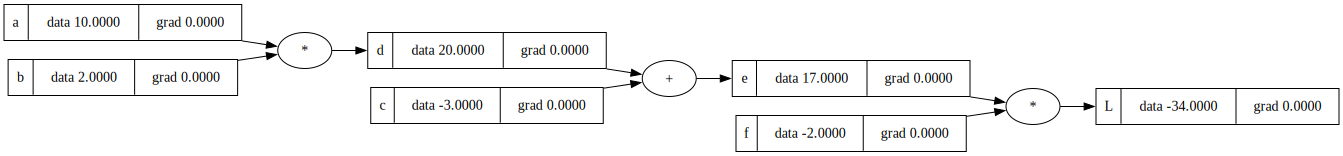

In [9]:
draw_dot(L)

In [10]:
def der():
  
    h = 0.001
  
    a = Value(10.0); a.label = 'a'
    b = Value(2.0); b.label = 'b'
    c = Value(-3.0); c.label = 'c'
    d = a*b; d.label = 'd'
    e = d+c; e.label = 'e'
    f = Value(-2.0); f.label = 'f'
    L = e*f; L.label = 'L'
    L1 = L.data
  
    a = Value(10.0); a.label = 'a'
    b = Value(2.0); b.label = 'b'
    b.data += h
    c = Value(-3.0); c.label = 'c'
    d = a*b; d.label = 'd'
    e = d+c; e.label = 'e'
    f = Value(-2.0); f.label = 'f'
    L = e*f; L.label = 'L'
    L2 = L.data
      
    print((L2 - L1)/h)
  
der()
a.grad = -4.0
b.grad = -20.0

-19.99999999999602


In [11]:
# Forward Propagation
x1 = Value(2.0, label="x1")
x2 = Value(1.0, label="x2")

w1 = Value(-1.0, label="w1")
w2 = Value(2.0, label="w2")

b = Value(1.5, label="b")

x1w1 = x1*w1; x1w1.label="x1w1"
x2w2 = x2*w2; x2w2.label="x2w2"
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label="x1w1 + x2w2"

n = x1w1x2w2 + b; n.label="n"
# o = n.tanh(); o.label="o"
e = (2*n).exp()
o = (e - 1) / (e + 1)
o.label = "o"

In [12]:
o.backward()

## draw_dot(o)

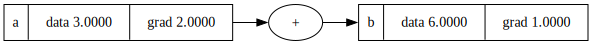

In [13]:
a = Value(3.0, label='a')
b = a + a   ; b.label = 'b'
b.backward()
draw_dot(b)

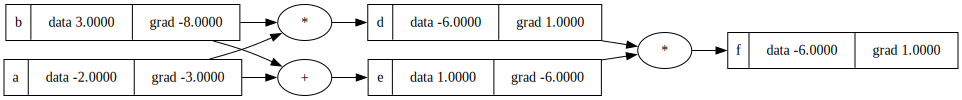

In [14]:
a = Value(-2.0, label='a')
b = Value(3.0, label='b')
d = a * b    ; d.label = 'd'
e = a + b    ; e.label = 'e'
f = d * e    ; f.label = 'f'

f.backward()

draw_dot(f)

In [15]:
a / b

Value(data=-0.6666666666666666)

In [16]:
1 + a, 2 * a

(Value(data=-1.0), Value(data=-4.0))

In [17]:
b - a

Value(data=5.0)

In [18]:
import torch

In [19]:
a = torch.Tensor([3.0])
print(a.data.item(), a.data)

3.0 tensor([3.])


In [20]:
x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


## MLP

In [21]:
class Neuron:
    def __init__(self, n_input):
        self.w = [Value(random.uniform(-1, 1)) for _ in range(n_input)]
        self.b = Value(random.uniform(-1, 1))
        
    def __call__(self, X):
        # w*x + b
        act = sum((wi*xi for wi, xi in zip(self.w, X)), self.b)
        out = act.tanh()
        return out

    def parameters(self):
        return self.w + [self.b]

class Layer:
    def __init__(self, n_input, n_output):
        """
        n_input : no of features in your X
        n_output : no of neurons per hidden layer
        """
        self.neurons = [Neuron(n_input) for _ in range(n_output)]

    def __call__(self, X):
        outs = [n(X) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

    def parameters(self):
        return [p for neurons in self.neurons for p in neurons.parameters()]

class MLP:
    """
    n_outputs : *List* of all the neurons we want in our Network
    """
    def __init__(self, n_input, n_outputs:list):
        sz = [n_input] + n_outputs
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(n_outputs))]

    def __call__(self, X):
        for layer in self.layers:
            X = layer(X)
        return X

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]
        

# x = [1.0, 3.0]
# n = MLP(2, [3, 3, 1])
# n(x)

## Finding loss on toy dataset

In [22]:
n = MLP(3, [3, 3, 1])
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0]

In [23]:
for k in range(500):
    # forward pass
    ypreds = [n(x) for x in xs]
    loss = sum((ypred - y)**2 for ypred, y in zip(ypreds, ys))

    # setting grads to zero
    for p in n.parameters():
        p.grad = 0.0
    
    # backward pass
    loss.backward()

    # gradient descent
    for p in n.parameters():
        p.data += -0.1 * p.grad

    print(k, loss)

0 Value(data=2.8752927096800622)
1 Value(data=1.084557028947143)
2 Value(data=0.4235181579053301)
3 Value(data=0.22990229667014728)
4 Value(data=0.18143741993506274)
5 Value(data=0.14912172818867858)
6 Value(data=0.12616070575550156)
7 Value(data=0.10907357418378522)
8 Value(data=0.09589900909202073)
9 Value(data=0.0854529253975054)
10 Value(data=0.07698069682810617)
11 Value(data=0.06997989019966057)
12 Value(data=0.06410369638820777)
13 Value(data=0.059105376001479706)
14 Value(data=0.054804811381982135)
15 Value(data=0.05106757550579606)
16 Value(data=0.047791392031734825)
17 Value(data=0.0448971207093482)
18 Value(data=0.04232260232248862)
19 Value(data=0.040018361364784406)
20 Value(data=0.03794454563850282)
21 Value(data=0.036068707683120683)
22 Value(data=0.034364170527698995)
23 Value(data=0.03280880629988529)
24 Value(data=0.03138411128090872)
25 Value(data=0.030074496969698432)
26 Value(data=0.028866740675169172)
27 Value(data=0.027749555388108735)
28 Value(data=0.02671324985

In [24]:
ypreds

[Value(data=0.9838727391219965),
 Value(data=-0.9809974072473259),
 Value(data=-0.9823967627732795),
 Value(data=0.9802606676916822)]

In [25]:
n.layers[0].neurons[0].w[0].grad

0.00010903134001436904

In [26]:
n.layers[0].neurons[0].w[0].data

0.35770266283335866